In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import TfidfModel

#spacy
import spacy

#vis
import pyLDAvis
import pyLDAvis.gensim

In [11]:
# Load data
data = pd.read_json("dataset_1M.json", lines=True)

In [3]:
# View some samples
data.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,False,"05 1, 2015",A8WEXFRWX1ZHH,0209688726,{'Color:': ' AC'},Goldengate,"After I wrote the below review, the manufactur...",Works well if you place phone in horizontally ...,1430438400,None,None
1,1,True,"04 19, 2018",ABCA1A8E4DGV1,0209688726,{'Color:': ' Blue'},noe,It sucks barely picks up anything definitely n...,sucks,1524096000,None,None
2,1,True,"04 16, 2018",A1NX8HM89FRQ32,0209688726,{'Color:': ' Black'},Eduard,"Well to write a short one, it blew 2 fuses of ...",Defective,1523836800,None,None
3,3,True,"04 13, 2018",A1X77G023NY0KY,0209688726,{'Color:': ' CA'},Lauren,I have absolutely no memory of buying this but...,Looks cool! Probably works,1523577600,None,None
4,5,True,"04 8, 2018",A3GK37JO2MGW6Q,0209688726,{'Color:': ' Black'},danny,it ok it does it job,Five Stars,1523145600,None,None


In [4]:
# Calculate counts for each column
data.count()

overall           1000000
verified          1000000
reviewTime        1000000
reviewerID        1000000
asin              1000000
style              358331
reviewerName       999917
reviewText         999636
summary            999862
unixReviewTime    1000000
vote               121947
image               16345
dtype: int64

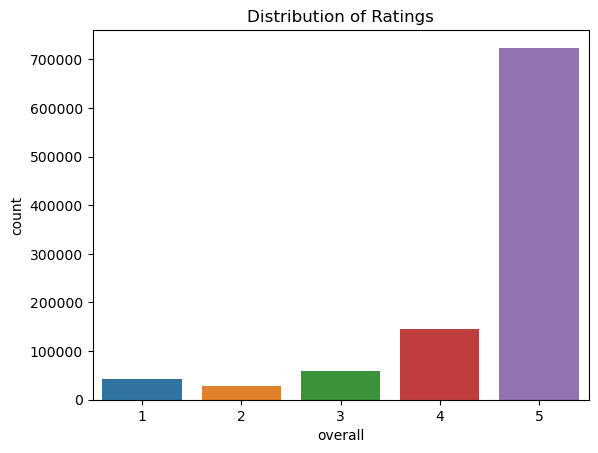

In [5]:
# Plot frequencies of ratings
sns.countplot(x='overall', data=data)
plt.title('Distribution of Ratings')
plt.show()

In [12]:
# Replace Nones with empty strings
data.fillna("", inplace=True)

In [7]:
# Select reviewText from df
reviews = data.reviewText.to_list()
# Remove empty reviews
reviews = [x for x in reviews if x]

In [8]:
# Remove HTML from reviews
CLEANR = re.compile('<.*?>')

def cleanhtml(text):
    cleantext = [re.sub(CLEANR, '', line) for line in text]
    return cleantext

cleaned_reviews = cleanhtml(reviews)

In [43]:
# Lemmatrize words
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

%time lemmatized_texts = lemmatization(cleaned_reviews)

Wall time: 1h 22s


In [44]:
# Save the list to a file
with open('lemmatized_texts.txt', 'w') as file:
    for item in lemmatized_texts:
        file.write(item + '\n')

In [1]:
# Load the list from the file
lemmatized_texts = []
with open('lemmatized_texts.txt', 'r') as file:
    for line in file:
        lemmatized_texts.append(line.strip())

In [3]:
# Split texts into lists of words
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words = gen_words(lemmatized_texts)

In [4]:
# Add bigrams and trigrams
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

In [5]:
# Remove words that are too frequent and don't have much value using TF-IDF
id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

In [ ]:
# Train LDA model
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=10,
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=2,
    alpha="auto"
)

In [ ]:
model_path = "./model_weights/lda_model/lda_model"

In [21]:
# Save LDA Model
lda_model.save(model_path)

In [ ]:
# Load LDA Model
lda_model = gensim.models.ldamodel.LdaModel.load(model_path)

In [8]:
# Visualize results of topic modeling
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds="mmds", R=30)

In [9]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
48     0.084516  0.396987       1        1  5.817193
39     0.262157  0.153999       2        1  3.989994
42    -0.124291  0.327292       3        1  3.825052
40    -0.139750  0.511535       4        1  3.665112
10     0.503285 -0.102039       5        1  3.447975
14     0.398326  0.059809       6        1  3.327383
19     0.042551  0.528276       7        1  3.317786
25    -0.496984 -0.195490       8        1  3.085049
24    -0.401277  0.332457       9        1  2.878286
5      0.279948  0.444918      10        1  2.781580
36     0.409585  0.328397      11        1  2.751272
20    -0.057033  0.454697      12        1  2.728655
1     -0.468137  0.140886      13        1  2.725405
0     -0.285436  0.449918      14        1  2.565705
3      0.038394  0.050670      15        1  2.458684
17    -0.263906  0.367929      16        1  2.448311
8     -0.036710  0.195814      17        1  2.430879
43    -0.519939  0.052006      18        1  2.350581
44     0.161800  0.264658      19        1  2.261999
26     0.451021  0.226545      20        1  2.163398
2     -0.197437  0.070466      21        1  2.047598
7      0.117966 -0.498400      22        1  1.932662
35     0.306901  0.333732      23        1  1.853162
22    -0.316701 -0.387704      24        1  1.831393
34    -0.322707 -0.120680      25        1  1.812734
11     0.235015 -0.011351      26        1  1.795864
29     0.466053 -0.205190      27        1  1.794944
37    -0.403177 -0.214739      28        1  1.790343
4      0.344274 -0.162359      29        1  1.788257
13    -0.157169 -0.405802      30        1  1.785237
31    -0.392392 -0.328143      31        1  1.775702
32     0.215503 -0.374154      32        1  1.728234
27    -0.505241 -0.063242      33        1  1.667981
41     0.337226 -0.373035      34        1  1.622828
23     0.417943 -0.308238      35        1  1.570970
16     0.509891  0.000685      36        1  1.550579
28     0.498069  0.125545      37        1  1.353646
46     0.229986 -0.468763      38        1  1.308791
47    -0.235189 -0.470535      39        1  1.305459
30    -0.095425 -0.510763      40        1  1.131339
21    -0.360630  0.020114      41        1  0.976023
18    -0.442071  0.230763      42        1  0.964811
49     0.199170 -0.203548      43        1  0.925825
9      0.016383 -0.501702      44        1  0.925024
12     0.166453  0.471655      45        1  0.886827
38    -0.279145  0.208291      46        1  0.825360
33    -0.051622 -0.206509      47        1  0.007028
45    -0.049948 -0.208746      48        1  0.007028
6     -0.045162 -0.213431      49        1  0.007028
15    -0.044937 -0.213482      50        1  0.007028, topic_info=            Term           Freq          Total Category  logprob  loglift
148        great  370724.000000  370724.000000  Default  30.0000  30.0000
118         work  389929.000000  389929.000000  Default  29.0000  29.0000
110          use  372985.000000  372985.000000  Default  28.0000  28.0000
43          good  297113.000000  297113.000000  Default  27.0000  27.0000
190         well  270858.000000  270858.000000  Default  26.0000  26.0000
..           ...            ...            ...      ...      ...      ...
22       current       0.018168   13848.810262  Topic50 -11.1066  -3.9810
23   description       0.018168    6269.496288  Topic50 -11.1066  -3.1885
25     direction       0.018168   10605.598535  Topic50 -11.1066  -3.7142
27        easily       0.018168   23412.302117  Topic50 -11.1066  -4.5061
28          else       0.018168   12550.385742  Topic50 -11.1066  -3.8826

[2161 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
236      18  0.999955        able
821      41  0.998530    absolute
135      13  0.999860  absolutely
705      12  0.999741      access
439      11  0.999723   accessory
...     ...       ...         ...
820

In [13]:
# Remove where reviewText is empty
data = data[data.reviewText != ""]
data.count()

overall           999636
verified          999636
reviewTime        999636
reviewerID        999636
asin              999636
style             999636
reviewerName      999636
reviewText        999636
summary           999636
unixReviewTime    999636
vote              999636
image             999636
dtype: int64

In [14]:
# Generate topic vectors for all texts
text_vectors = [lda_model[text] for text in corpus]

In [15]:
# Add topics to data
num_topics = 50
for i in range(num_topics):
    topic = []
    for vector in text_vectors: 
        try:
            if vector[i][0] == i:
                topic.append(vector[i][1])
            else:
                topic.append(0.0)
        except:
            topic.append(0.0)
    data[f"topic_{i}"] = topic

In [78]:
data.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,...,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,4,False,"05 1, 2015",A8WEXFRWX1ZHH,0209688726,{'Color:': ' AC'},Goldengate,"After I wrote the below review, the manufactur...",Works well if you place phone in horizontally ...,1430438400,...,0.164398,0.019885,0.092497,0.324401,0.022822,0.193271,0.021232,0.026883,0.076481,0.058130
1,1,True,"04 19, 2018",ABCA1A8E4DGV1,0209688726,{'Color:': ' Blue'},noe,It sucks barely picks up anything definitely n...,sucks,1524096000,...,0.201971,0.036698,0.132437,0.183809,0.071552,0.140502,0.064924,0.065392,0.066445,0.036270
2,1,True,"04 16, 2018",A1NX8HM89FRQ32,0209688726,{'Color:': ' Black'},Eduard,"Well to write a short one, it blew 2 fuses of ...",Defective,1523836800,...,0.197564,0.035896,0.041449,0.179794,0.113867,0.203494,0.063505,0.063962,0.064993,0.035477
3,3,True,"04 13, 2018",A1X77G023NY0KY,0209688726,{'Color:': ' CA'},Lauren,I have absolutely no memory of buying this but...,Looks cool! Probably works,1523577600,...,0.155038,0.031704,0.036608,0.333781,0.042360,0.140833,0.075542,0.056492,0.096308,0.031334
4,5,True,"04 8, 2018",A3GK37JO2MGW6Q,0209688726,{'Color:': ' Black'},danny,it ok it does it job,Five Stars,1523145600,...,0.218884,0.044759,0.051684,0.169281,0.059804,0.171366,0.079186,0.079756,0.081041,0.044238


In [16]:
# Add product_rating as int
data['product_rating'] = data['overall']
data['product_rating'] = data['product_rating'].astype(int)

In [17]:
topic_cols = [f"topic_{i}" for i in range(num_topics)]

topic_ratings = data.groupby('product_rating')[topic_cols].mean()

In [18]:
topic_ratings

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_40,topic_41,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48,topic_49
product_rating,,,,,,,,,,,,,,,,,,,,,
1,0.024748,0.027130,0.020138,0.026829,0.017703,0.029381,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.024827,0.027336,0.020450,0.025641,0.017988,0.028712,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.024989,0.027965,0.020926,0.025153,0.017960,0.028748,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.024610,0.028088,0.020750,0.024715,0.017887,0.029282,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.024633,0.028357,0.020106,0.024977,0.018005,0.030720,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Figure size 1000x600 with 0 Axes>

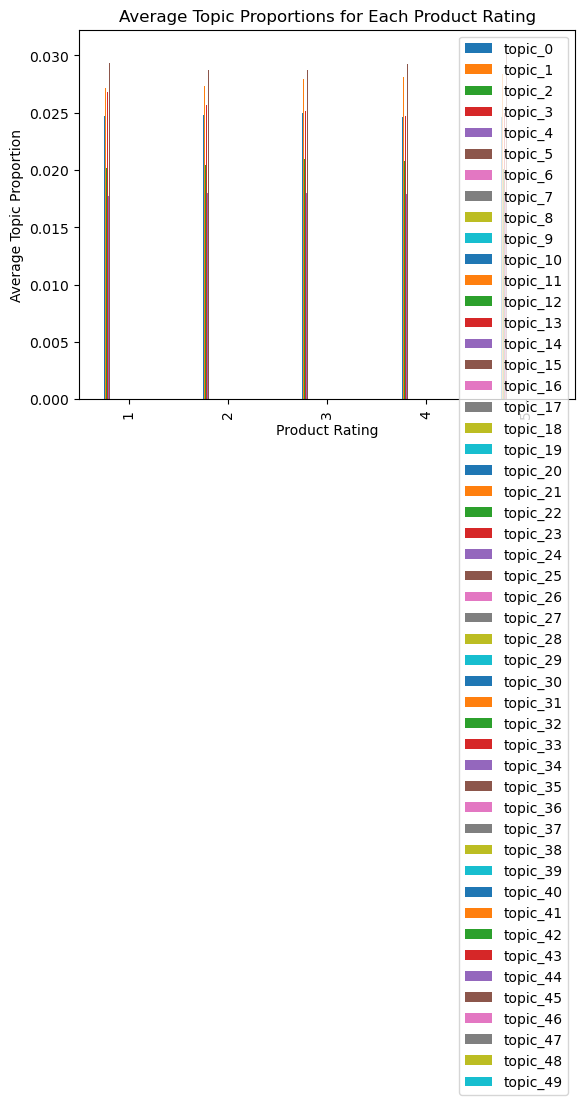

In [19]:
plt.figure(figsize=(10, 6))
topic_ratings.plot(kind='bar')
plt.xlabel('Product Rating')
plt.ylabel('Average Topic Proportion')
plt.title('Average Topic Proportions for Each Product Rating')
plt.legend(loc='upper right')
plt.show()